In [ ]:
from google.colab import drive
from pathlib import Path
from PIL import Image
import requests

import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def display_images(image_dict):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 1, 1 for test
    fig.tight_layout()

    for i, (title, image) in enumerate(image_dict.items()):
        row = i // 3
        col = i % 3
        axes[row, col].imshow(image)
        axes[row, col].set_title(title)
        axes[row, col].axis("off")

    plt.show()


def crop_center_square(arr, max_dim: int = 1000):
    """
    Selects up to the center max_pixels from an nxnxc input array, or n pixels if 1000 > n,
    where c is the number of channels (e.g., 3 for an RGB image).

    Parameters:
        arr (np.ndarray): The input array from which to select pixels, with shape (n, n, c).
        max_pixels (int): The maximum number of pixels to select if possible (default is 1000).

    Returns:
        np.ndarray: The selected portion of the input array, maintaining the channel dimension.
    """
    print(arr.shape)
    if arr.ndim > 3 or arr.ndim < 2:
        raise ValueError(
            "Unable to crop center of array with number of dimensions:"
            + f" {arr.ndim}, must have only 2 or 3 dimensions."
        )
    if max_dim > arr.shape[0]:
        return arr
    # Calculate starting indices to select the square from the center
    start_index = (arr.shape[0] - max_dim) // 2
    start_index = start_index + ((start_index // 20) * 19)

    # Select the square, preserving the channel dimension
    if arr.ndim == 3:
        selected_square = arr[start_index:start_index + max_dim, start_index:start_index + max_dim, :]
    elif arr.ndim == 2:
        selected_square = arr[start_index:start_index + max_dim, start_index:start_index + max_dim]
    print(selected_square.shape)

    return selected_square


def brighten(band: np.ndarray):
    """Adjust image brightness using an alpha value (0 to 1). Higher alpha increases brightness, lower decreases."""

    alpha=0.2 # you can change this value
    beta=0
    return np.clip(alpha*band+beta, 0,255)

def normalize(band: np.ndarray) -> np.ndarray:
    """
    First brighten the bands and then return normalized image
    """
    band = brighten(band)
    band_min, band_max = (band.min(), band.max())

    return ((band-band_min)/((band_max - band_min)))


def display_transformed_images(data_path: Path):
    """
    Generate Sentinel-2 images from the given filepath. The returned images are as follows:
       NDVI: Normalized Difference Vegetation Index
       NDVI705: Normalized Difference Vegetation Index (705m)
       NDBI: Normalized Difference Built-up Index
       NDWI: Normalized Difference Water Index
       False Color: B08, B04, B03
       Mask: The class labels for each pixel

    Please Note: If the size of the input

    Note: If the input tile contains 0 values (ie. black squares in the tiles),
      a warning will be printed due to division by zero.
    """
    # Unpack the bands
    band_size = tiff.imread(f"{data_path}/B02.tiff").shape
    print(band_size)

    B02 = normalize(
            tiff.imread(f"{data_path}/B02.tiff"),)
    B03 = normalize(
            tiff.imread(f"{data_path}/B03.tiff"),)
    B04 = normalize(
            tiff.imread(f"{data_path}/B04.tiff"),)
    B05 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B05.tiff"),
                band_size[::-1]# make sure the dimensions of B11 is the same as the other bands after resizing
            ))
    B08 = normalize(
            tiff.imread(f"{data_path}/B08.tiff"),)

    B11 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B11.tiff"),
                band_size[::-1]# make sure the dimensions of B11 is the same as the other bands after resizing
            ))

    B12 = normalize(
            cv2.resize(
                tiff.imread(f"{data_path}/B12.tiff"),
                band_size[::-1]
            ))

    # Calculate NDVI (Normalized Difference Vegetation Index)
    NDVI = (B08 - B04) / (B08 + B04)

    # Calculate NDVI705
    NDVI705 = (B05 - B04) / (B05 + B04)

    # Calculate NDBI (Normalized Difference Built-Up Index)
    NDBI = (B11 - B08) / (B11 + B08)

    # # Calculate NDWI (Normalized Difference Water Index)
    NDWI = (B08 - B12) / (B08 + B12)

    # # Calculate NBR (Normalized Burn Ratio)
    NBR = (B08 - B12) / (B08 + B12)

    # Create a color image using RGB bands
    RGB = np.stack([B04, B03, B02], axis=-1)

    images = {
        "NDVI": NDVI,
        "NDVI705": NDVI705,
        "NDBI": NDBI,
        "NDWI": NDWI,
        "NBR": NBR,
        "RGB": RGB,
        # "False Color": false_color,
    }

    display_images(images)

    return images

(585, 844)


<ipython-input-3-30cb3a367ebc>:112: RuntimeWarning: invalid value encountered in divide
  NDVI = (B08 - B04) / (B08 + B04)
<ipython-input-3-30cb3a367ebc>:115: RuntimeWarning: invalid value encountered in divide
  NDVI705 = (B05 - B04) / (B05 + B04)
<ipython-input-3-30cb3a367ebc>:118: RuntimeWarning: invalid value encountered in divide
  NDBI = (B11 - B08) / (B11 + B08)
<ipython-input-3-30cb3a367ebc>:121: RuntimeWarning: invalid value encountered in divide
  NDWI = (B08 - B12) / (B08 + B12)
<ipython-input-3-30cb3a367ebc>:124: RuntimeWarning: invalid value encountered in divide
  NBR = (B08 - B12) / (B08 + B12)


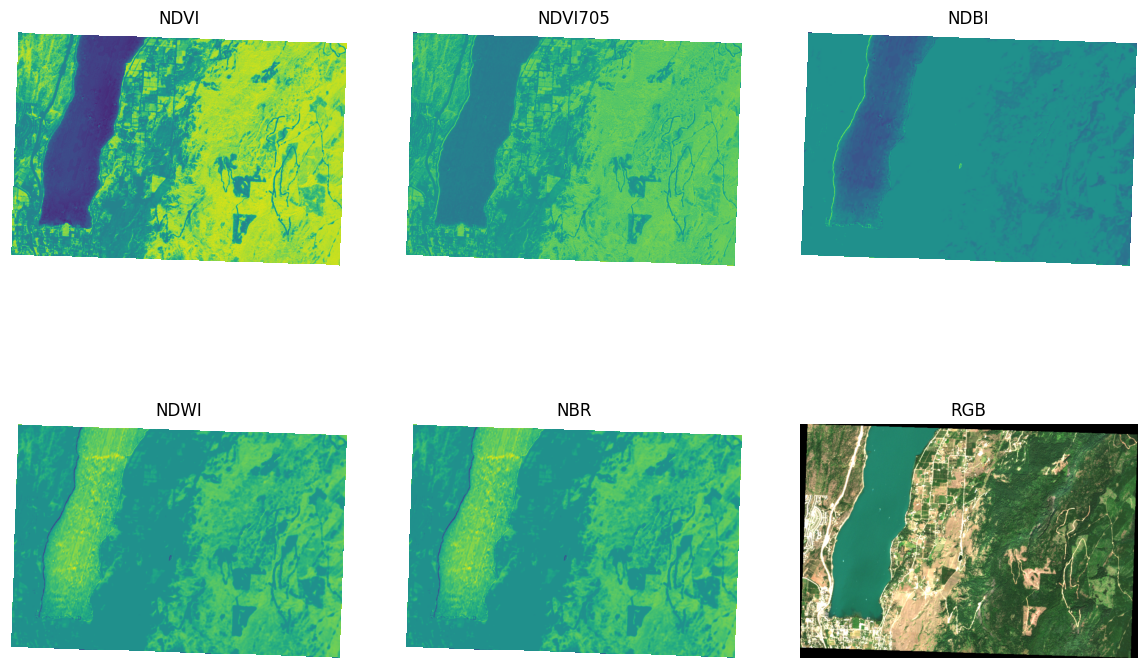

In [ ]:
cropped_tile_path = "/content/drive/MyDrive/okanagan/cropped"  # TODO put the path to the tile here

images = display_transformed_images(cropped_tile_path)

In [ ]:
# Import ground truth and convert PIL Image to NumPy array
gt = Image.open('/content/okanagan.tif')
gt_array = np.array(gt)

# resize gt
gt_array = cv2.resize(gt_array, (images["RGB"].shape[1], images["RGB"].shape[0]))

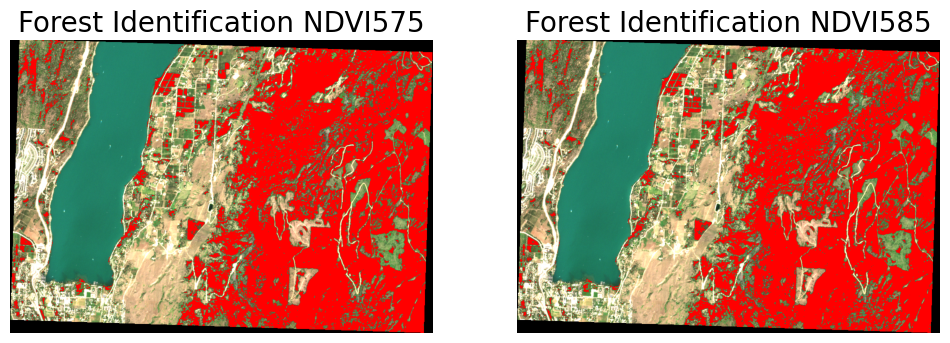

In [ ]:
RGB = images["RGB"]
NDVI = images["NDVI"]
ratio_575 = 0.575 #Adjust vegetation_ratio
ratio_585 = 0.585

# Create an NDVI mask
ndvi_mask_575 = NDVI > ratio_575
ndvi_mask_585 = NDVI > ratio_585

# Apply the masks
forest_ndvi_575 = RGB.copy()
forest_ndvi_585 = RGB.copy()
for i in range(RGB.shape[0]):
    for j in range(RGB.shape[1]):
        if ndvi_mask_575[i, j]:
            forest_ndvi_575[i, j] = [255, 0, 0]  # Mark forest pixels in red
        if ndvi_mask_585[i, j]:
            forest_ndvi_585[i, j] = [255, 0, 0]  # Mark forest pixels in red

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(forest_ndvi_575)
axes[0].set_title("Forest Identification NDVI575", fontsize=20)
axes[0].axis("off")

axes[1].imshow(forest_ndvi_585)
axes[1].set_title("Forest Identification NDVI585", fontsize=20)
axes[1].axis("off")

plt.show()

Accuracy of NDVI 575:  0.7601915988171912
Accuracy of NDVI 585:  0.7572122979705919


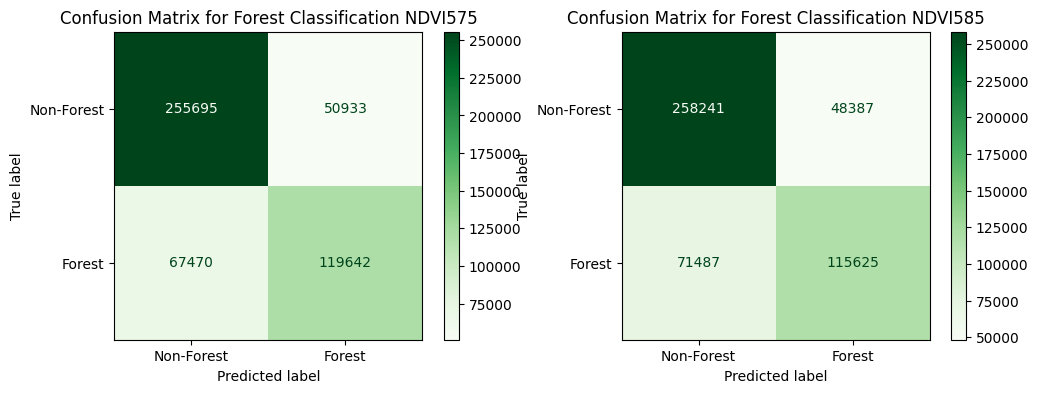

In [ ]:
# determine the accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# unclassified
ignore_vals = [[104,104,104]]
# Wetland-treed #9933cc->[153, 51, 204], Coniferous #006600->[0, 102, 0], Broadleaf #00cc00->[0,204,0], Mixedwood #cc9900->[204, 153, 0]
tree_vals = [[153, 51, 204], [0, 102, 0], [0, 204, 0], [204, 153,0]]

truth = []
ndvi575_predictions = []
ndvi585_predictions = []

rows, cols, _ = gt_array.shape

for i in range(rows):
    for j in range(cols):
        truth_pixel = [gt_array[i][j][0], gt_array[i][j][1], gt_array[i][j][2]]
        if truth_pixel in ignore_vals:
            continue
        if truth_pixel in tree_vals:
            truth.append(1)
        else:
            truth.append(0)

     # Add forest identification (from algorithm) to predictions
        forest_575_pixel = [forest_ndvi_575[i][j][0], forest_ndvi_575[i][j][1], forest_ndvi_575[i][j][2]]
        if forest_575_pixel == [255, 0, 0]:
            ndvi575_predictions.append(1)
        else:
            ndvi575_predictions.append(0)

        forest_585_pixel = [forest_ndvi_585[i][j][0], forest_ndvi_585[i][j][1], forest_ndvi_585[i][j][2]]
        if forest_585_pixel == [255, 0, 0]:
            ndvi585_predictions.append(1)
        else:
            ndvi585_predictions.append(0)

# Create confusion matrices
cm_forest_575 = confusion_matrix(truth, ndvi575_predictions)
print("Accuracy of NDVI 575: ", accuracy_score(truth, ndvi575_predictions))
cm_forest_585 = confusion_matrix(truth, ndvi585_predictions)
print("Accuracy of NDVI 585: ", accuracy_score(truth, ndvi585_predictions))


# Display two confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
display_forest_575 = ConfusionMatrixDisplay(confusion_matrix=cm_forest_575, display_labels=['Non-Forest', 'Forest'])
display_forest_575.plot(values_format='', cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix for Forest Classification NDVI575")
display_forest_585 = ConfusionMatrixDisplay(confusion_matrix=cm_forest_585, display_labels=['Non-Forest', 'Forest'])
display_forest_585.plot(values_format='', cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix for Forest Classification NDVI585")
plt.show()

In [ ]:
# Extract TP, FP, FN, and TN
TP = cm_forest_575[0, 0]
FP = cm_forest_575[0, 1]
FN = cm_forest_575[1, 0]
TN = cm_forest_575[1, 1]

# Calculate Recall
recall = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"575 Recall: {recall}")
print(f"575 Precision: {precision}")
print(f"575 F1 Score: {f1_score}")

575 Recall: 0.7912212027911438
575 Precision: 0.8338931865322149
575 F1 Score: 0.8119969577305558


In [ ]:
# Extract TP, FP, FN, and TN
TP = cm_forest_585[0, 0]
FP = cm_forest_585[0, 1]
FN = cm_forest_585[1, 0]
TN = cm_forest_585[1, 1]

# Calculate Recall
recall = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"585 Recall: {recall}")
print(f"585 Precision: {precision}")
print(f"585 F1 Score: {f1_score}")

585 Recall: 0.7831940265916149
585 Precision: 0.8421964073731035
585 F1 Score: 0.8116243109203024


#Sobel

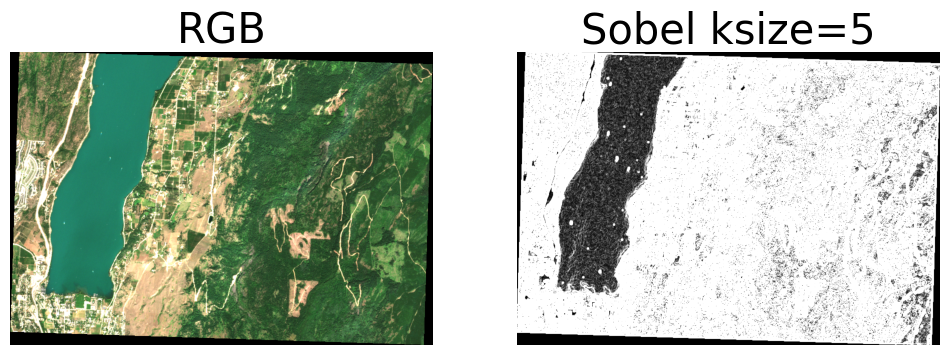

In [ ]:
# Figure for visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Convert to uint 8 bit image
image = copy.deepcopy(images["RGB"])
image *= 255
image = image // 1
image = image.astype(np.uint8)

# Display RGB
axes[0].imshow(image)
axes[0].set_title("RGB", fontsize=30)
axes[0].axis("off")

# Calculate and display edges
greyscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Calculate the Sobel gradients in the x and y directions
sobelx = cv2.Sobel(greyscale, cv2.CV_32F, 1, 0, ksize=5)  # ksize is the kernel size
sobely = cv2.Sobel(greyscale, cv2.CV_32F, 0, 1, ksize=5)

# Combine the Sobel gradients to get the overall edge response
sobel_combined = cv2.magnitude(sobelx, sobely)

# Convert the result back to 8-bit for display purposes
sobel_combined = cv2.convertScaleAbs(sobel_combined)

axes[1].imshow(sobel_combined, cmap='gray')
axes[1].set_title("Sobel ksize=5", fontsize=30)
axes[1].axis("off")

plt.show()

NDVI+Sobel 80 accuracy:  0.7534613359257909


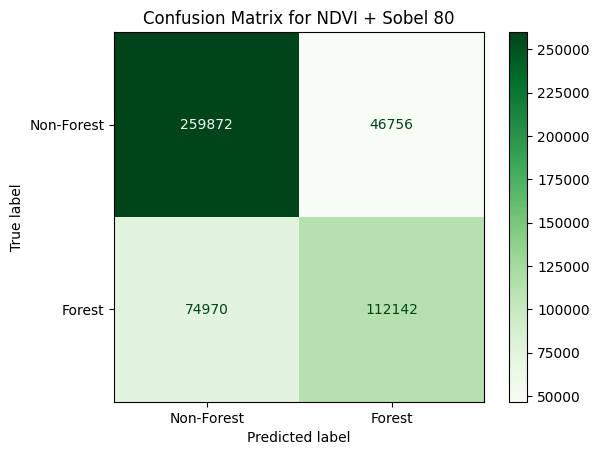

In [ ]:
mask_80 = sobel_combined > 80

# Apply the mask
sobel80_ndvi = image.copy()
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if mask_80[i, j] and ndvi_mask_585[i, j]:
            sobel80_ndvi[i, j] = [255, 0, 0]

sobel80_predictions = []

for i in range(rows):
  for j in range(cols):
     # Add forest identification (from algorithm) to predictions
        forest_pixel = [sobel80_ndvi[i][j][0], sobel80_ndvi[i][j][1], sobel80_ndvi[i][j][2]]
        if forest_pixel == [255, 0, 0]:
            sobel80_predictions.append(1)
        else:
            sobel80_predictions.append(0)

# Create confusion matrices
cm_forest_80 = confusion_matrix(truth, sobel80_predictions)
print("NDVI+Sobel 80 accuracy: ", accuracy_score(truth, sobel80_predictions))

# Display the confusion matrices
display_forest = ConfusionMatrixDisplay(confusion_matrix=cm_forest_80, display_labels=['Non-Forest', 'Forest'])
display_forest.plot(values_format='', cmap="Greens")
plt.title("Confusion Matrix for NDVI + Sobel 80")
plt.show()

In [ ]:
# Extract TP, FP, FN, and TN
TP = cm_forest_80[0, 0]
FP = cm_forest_80[0, 1]
FN = cm_forest_80[1, 0]
TN = cm_forest_80[1, 1]

# Calculate Recall
recall = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"NDVI+Sobel 80 Recall: {recall}")
print(f"NDVI+Sobel 80 Precision: {precision}")
print(f"NDVI+Sobel 80 F1 Score: {f1_score}")

NDVI+Sobel 80 Recall: 0.7761033562097944
NDVI+Sobel 80 Precision: 0.8475155563092738
NDVI+Sobel 80 F1 Score: 0.8102389823374436


(-0.5, 843.5, 584.5, -0.5)

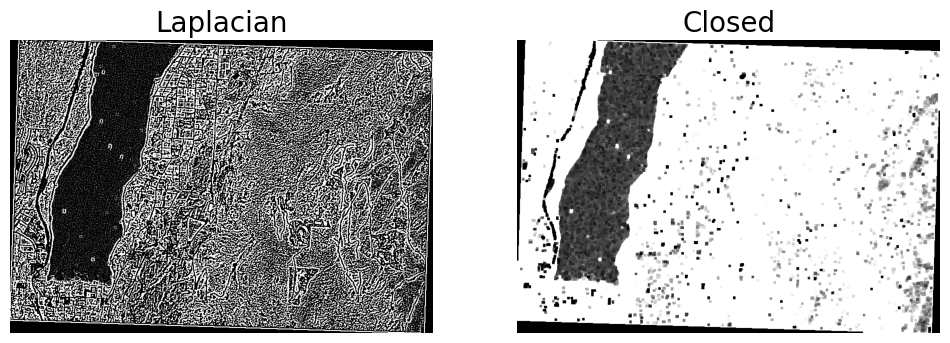

In [ ]:
laplacian = cv2.Laplacian(greyscale, cv2.CV_8U, ksize=5)  # kernel size may be affected by image resolution
# Calculate and display closed
kernel = np.ones((5,5),np.uint8)  # kernel size may be affected by image resolution
closed = cv2.morphologyEx(laplacian, cv2.MORPH_CLOSE, kernel)

# Figure for visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(laplacian, cmap='gray')
axes[0].set_title("Laplacian", fontsize=20)
axes[0].axis("off")
axes[1].imshow(closed, cmap='gray')
axes[1].set_title("Closed", fontsize=20)
axes[1].axis("off")

(-0.5, 843.5, 584.5, -0.5)

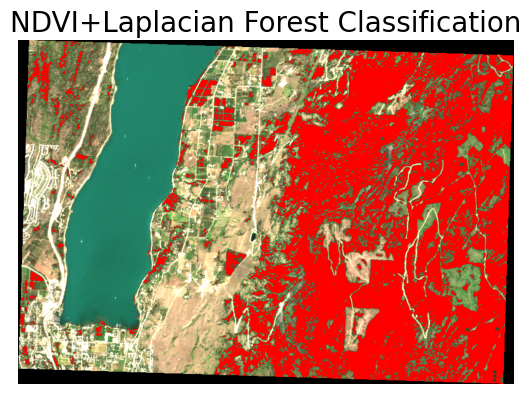

In [ ]:
# Apply the masks
lap_result = image.copy()
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if np.max(closed[i][j]) > 64 and ndvi_mask_585[i, j]:
            lap_result[i][j] = [255, 0, 0]

plt.imshow(lap_result)
plt.title("NDVI+Laplacian Forest Classification", fontsize=20)
plt.axis("off")

NDVI+Laplacian accuracy:  0.7568902661319723


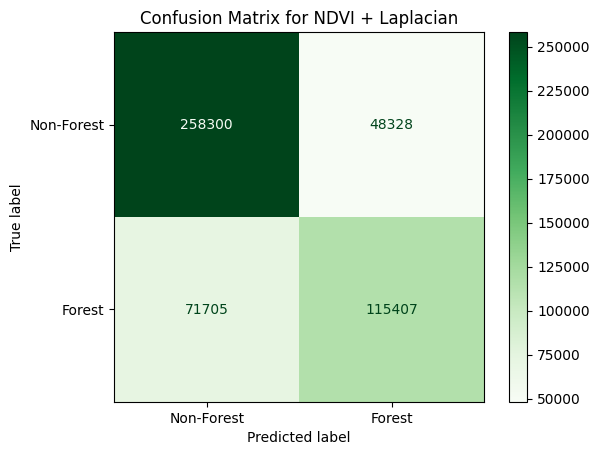

In [ ]:
lap_predictions = []

for i in range(rows):
  for j in range(cols):
     # Add forest identification (from algorithm) to predictions
        forest_pixel = [lap_result[i][j][0], lap_result[i][j][1], lap_result[i][j][2]]
        if forest_pixel == [255, 0, 0]:
            lap_predictions.append(1)
        else:
            lap_predictions.append(0)

# Create confusion matrices
cm_forest_lap = confusion_matrix(truth, lap_predictions)
print("NDVI+Laplacian accuracy: ", accuracy_score(truth, lap_predictions))

# Display the confusion matrices
display_forest = ConfusionMatrixDisplay(confusion_matrix=cm_forest_lap, display_labels=['Non-Forest', 'Forest'])
display_forest.plot(values_format='', cmap="Greens")
plt.title("Confusion Matrix for NDVI + Laplacian")
plt.show()

In [ ]:
# Extract TP, FP, FN, and TN
TP = cm_forest_lap[0, 0]
FP = cm_forest_lap[0, 1]
FN = cm_forest_lap[1, 0]
TN = cm_forest_lap[1, 1]

# Calculate Recall
recall = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"NDVI+Laplacian Recall: {recall}")
print(f"NDVI+Laplacian Precision: {precision}")
print(f"NDVI+Laplacian F1 Score: {f1_score}")

NDVI+Laplacian Recall: 0.7827154134028272
NDVI+Laplacian Precision: 0.8423888229385444
NDVI+Laplacian F1 Score: 0.8114565220464538
